In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

# Objectif du notebook

Comparer les différentes modélisation possible sur la variable balance (production - consommation) :

* SARIMAX avec des fonctions sinusoïdales correspondant aux saisons observées en régresseurs exogènes
* SARIMAX avec des données métier en régresseurs exogènes (consommation et productions pilotées par l'Homme : nucléaire, thermique, hydraulique) et solaire (hypothèse de stabilité dans le temps).
* SARIMAX avec des données métier FILTREES en régresseurs exogènes
* SARIMAX sur le signal filtré par transformation de Fourier sans régresseur
* SARIMAX sur le signal filtré avec des données métier FILTREES en régresseurs exogènes
* Régression linéaire sur les données métiers FILTREES comme variables explicatives
* Régression linéaire sur la variable à expliquée FILTREE et avec les variables explicatives FILTREES.

**NOTA BENE :** Pour la période 3h, le calcul avec un modèle SARIMAX n'aboutit pas sans données exogènes en paramètre.

# Import du dataset original

In [2]:
df = pd.read_csv('./dataset/France_3H.csv',
                usecols = ['Dates', 'Balance'])
df.head(1)

,Dates,Balance
0,2013-01-01 00:00:00,6802.4


In [3]:
df['Dates'] = pd.to_datetime(df['Dates'], yearfirst = True)
df.set_index('Dates', inplace = True)

In [4]:
debut = dt.datetime(year = 2013, month = 1, day = 1)
fin = dt.datetime(year = 2020, month = 1, day = 1)

''

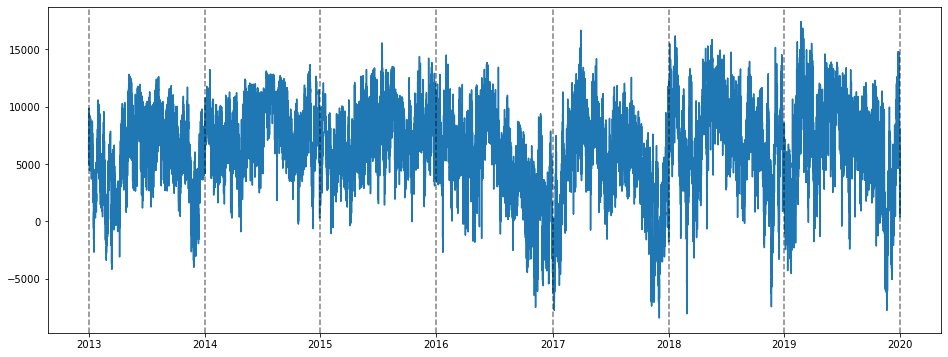

In [5]:
plt.figure(figsize=(16, 6))
plt.plot(df[(df.index >= debut) & (df.index < fin)])
for year in range(debut.year, fin.year + 1): 
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5)
;

### Test de stationnarité

In [6]:
# la 2ème valeur donne la p_value (stationnaire si < 5%)
sm.tsa.stattools.adfuller(df)

(-9.418055086202447,
 5.599467356158601e-16,
 49,
 25758,
 {'1%': -3.4306038998292085,
  '5%': -2.8616522161827964,
  '10%': -2.566829729367711},
 432727.5631942789)

### Coéfficients SARIMAX et saisonnalités

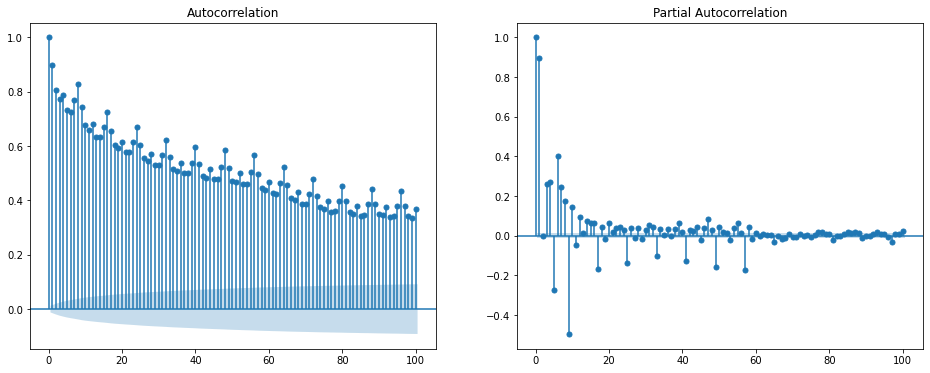

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
plot_acf(df, lags = 100, ax=ax1)
plot_pacf(df, lags = 100, ax=ax2)
plt.show()

**Saisonnalités :**
* 8 lags = 3h x 8 = 24h

# Import du dataset filtré (Transformation de Fourier)

In [8]:
df_filtered = pd.read_csv('./dataset/France_3H_filtered.csv',
                parse_dates = ['Dates'],
                usecols = ['Dates', 'Balance'])
df_filtered.set_index('Dates', inplace = True)
df_filtered.head(1)

,Balance
Dates,
2013-01-01,5793.132541


In [9]:
debut = dt.datetime(year = 2013, month = 1, day = 1)
fin = dt.datetime(year = 2020, month = 1, day = 1)

''

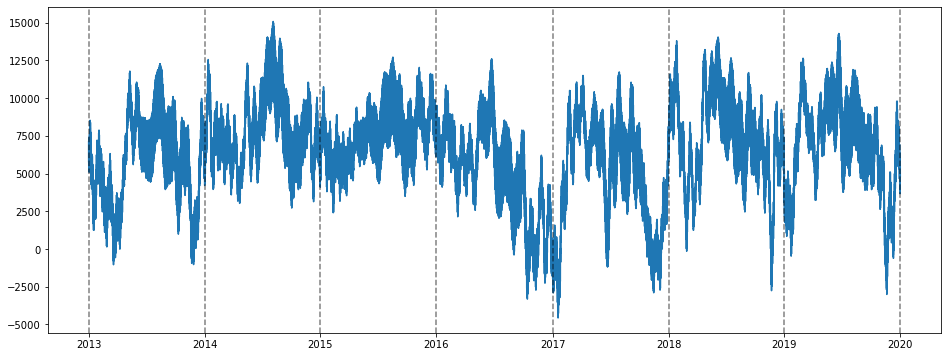

In [10]:
plt.figure(figsize=(16, 6))
plt.plot(df_filtered[(df_filtered.index >= debut) & (df_filtered.index < fin)])
for year in range(debut.year, fin.year + 1): 
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5)
;

# Jeux d'entrainement et de test

In [11]:
df_train = df[(df.index >= debut) & (df.index < fin)]
df_test = df[df.index >= fin]

In [12]:
df_train_filter = df_filtered[(df_filtered.index >= debut) & (df_filtered.index < fin)]
df_test_filter = df_filtered[df_filtered.index >= fin]

In [13]:
fenetre = df_test.shape[0]

In [14]:
indice = df_test.index

In [15]:
bilan = df_test

# Paramètres SARIMAX

In [16]:
ordre = (2,0,0)
saison = (1,0,1,8)

# Régresseurs exogènes : sinus & cosinus suivant les saisonnalités

In [17]:
exog = pd.DataFrame({'date': df.index})
exog['date'] = pd.to_datetime(exog['date'])
# suivant saisonnalités
# exog['sin_D'] = np.sin(2 * np.pi * exog.index / 8)
# exog['cos_D'] = np.cos(2 * np.pi * exog.index / 8)
# exog['sin_W'] = np.sin(2 * np.pi * exog.index / 7 / 8)
# exog['cos_w'] = np.cos(2 * np.pi * exog.index / 7 / 8)
exog['sin_Y'] = np.sin(2 * np.pi * exog.index / 365.25 / 8)
exog['cos_Y'] = np.cos(2 * np.pi * exog.index / 365.25 / 8)
exog.set_index('date', inplace = True)

In [18]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

<ipython-input-19-56416ee0eedf>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  plt.plot(exog[(exog.index >= pd.datetime(2016, 1, 1)) & (exog.index < pd.datetime(2016, 1, 15))])


''

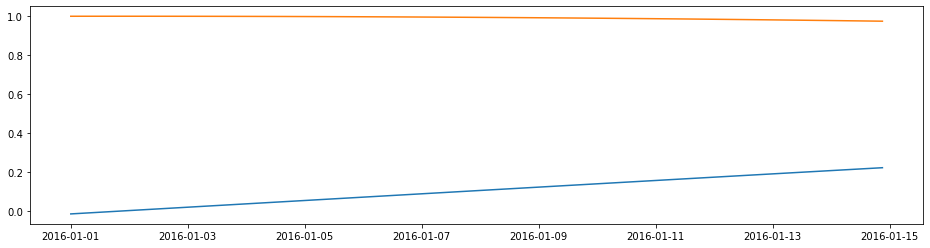

In [19]:
plt.figure(figsize=(16, 4))
plt.plot(exog[(exog.index >= pd.datetime(2016, 1, 1)) & (exog.index < pd.datetime(2016, 1, 15))])
# for year in range(debut.year, fin.year + 1): 
#     plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5)
;

### SARIMAX

In [20]:
model_sinus = sm.tsa.SARIMAX(df_train.values,
                             exog = exog_train.values,
                             order = ordre,
                             seasonal_order = saison)
result_sinus = model_sinus.fit()

In [21]:
predict_sinus = result_sinus.predict(start = 1 ,
                                     end = fenetre,
                                     exog = exog_test.values)

In [22]:
predict_sinus = pd.DataFrame(predict_sinus, columns=['Bal_p_sinus'], index = indice)

In [23]:
bilan = pd.concat([bilan, predict_sinus], axis = 1)

### Erreur absolue

In [24]:
bilan['Err_sinus'] = np.abs(bilan['Bal_p_sinus'] - bilan['Balance'])
bilan.describe()

,Balance,Bal_p_sinus,Err_sinus
count,5360.000000,5360.000000,5360.000000
mean,5852.513930,6607.105420,4109.909353
std,4555.144056,3172.190520,3173.677062
min,-11152.333333,-4046.402276,0.993297
25%,2626.291667,4690.277978,1554.944447
50%,6269.000000,6791.630227,3417.630125
75%,9323.541667,8890.643184,5936.449382
max,16412.666667,14303.737137,16307.262101


# Régresseurs exogènes : données métier

In [25]:
exog = pd.read_csv('./exog/exog_3H_FR.csv', sep = ';',
                   usecols = ['Dates', 'TCH_nucleaire', 'TCH_thermique', 'TCH_hydraulique', 'TCH_solaire'])
exog.head(1)

,Dates,TCH_nucleaire,TCH_thermique,TCH_hydraulique,TCH_solaire
0,2013-01-01 00:00:00,0.796988,0.553299,0.235903,0.0


In [26]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [27]:
conso = pd.read_csv('./dataset/France_3H.csv',# sep = ';',
                   usecols = ['Dates', 'Consommation'])
conso.set_index('Dates', inplace = True)
exog = pd.concat([exog, conso], axis = 1)
exog

,TCH_nucleaire,TCH_thermique,TCH_hydraulique,TCH_solaire,Consommation
Dates,,,,,
2013-01-01 00:00:00,0.796988,0.553299,0.235903,0.000000,57831.600000
2013-01-01 03:00:00,0.729313,0.545710,0.120321,0.000000,50945.833333
2013-01-01 06:00:00,0.693461,0.544864,0.099516,0.000000,48686.166667
2013-01-01 09:00:00,0.737153,0.548497,0.170796,0.053055,50578.000000
2013-01-01 12:00:00,0.788920,0.548746,0.245239,0.152397,55020.166667
...,...,...,...,...,...
2021-10-31 09:00:00,0.613736,0.418635,0.014000,0.217272,46282.000000
2021-10-31 12:00:00,0.603224,0.458143,0.006648,0.292940,47595.166667
2021-10-31 15:00:00,0.607127,0.493646,-0.001309,0.081937,43186.333333


In [28]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

### SARIMAX

In [29]:
model_exog = sm.tsa.SARIMAX(df_train.values,
                       exog = exog_train.values,
                       # mle_regression = False, # Default = True
                       # simple_differencing = True, #Default = False
                       # state_regression = False,
                       order = ordre,
                       seasonal_order = saison)

In [30]:
result_exog = model_exog.fit(low_memory=True)

C:\Python\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [31]:
result_exog.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                20448
Model:             SARIMAX(2, 0, 0)x(1, 0, [1], 8)   Log Likelihood             -156537.410
Date:                             Wed, 04 May 2022   AIC                         313094.819
Time:                                     09:59:39   BIC                         313174.076
Sample:                                          0   HQIC                        313120.722
                                           - 20448                                         
Covariance Type:                            approx                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          5.159e+04    295.160    174.789      0.000     5.1e+04    5.22e+04
x2          1328.5283     34.958     38.003      0.000    1260.012    1397.045
x3          1.658e+04    152.035    109.035      0.000    1.63e+04    1.69e+04
x4          3548.8611     94.219     37.666      0.000    3364.195    3733.527
x5            -0.7204      0.005   -159.149      0.000      -0.729      -0.712
ar.L1          1.3229      0.008    168.161      0.000       1.307       1.338
ar.L2         -0.4218      0.008    -55.963      0.000      -0.437      -0.407
ar.S.L8        0.9869      0.002    596.427      0.000       0.984       0.990
ma.S.L8       -0.8543      0.006   -137.737      0.000      -0.866      -0.842
sigma2      2.602e+05   3652.090     71.255      0.000    2.53e+05    2.67e+05
===================================================================================
Ljung-Box (L1) (Q):                  38.35   Jarque-Bera (JB):              2061.03
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.06   Skew:                             0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [32]:
predict_exog = result_exog.predict(start = 1 ,
                               end = fenetre,
                               exog = exog_test.values)

In [33]:
predict_exog = pd.DataFrame(predict_exog, index = indice, columns = ['Bal_p_exog'])

In [34]:
bilan = pd.concat([bilan, predict_exog], axis = 1)

### Erreur absolue

In [35]:
bilan['Err_exog'] = np.abs(bilan['Bal_p_exog'] - bilan['Balance'])
bilan.describe()

,Balance,Bal_p_sinus,Err_sinus,Bal_p_exog,Err_exog
count,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000
mean,5852.513930,6607.105420,4109.909353,6594.833999,4151.556553
std,4555.144056,3172.190520,3173.677062,3250.059374,3225.331933
min,-11152.333333,-4046.402276,0.993297,-4739.018635,1.561585
25%,2626.291667,4690.277978,1554.944447,4601.524999,1546.144263
50%,6269.000000,6791.630227,3417.630125,6788.453442,3422.365118
75%,9323.541667,8890.643184,5936.449382,9009.108535,6056.400883
max,16412.666667,14303.737137,16307.262101,13440.761653,17663.851968


# Régresseurs exogènes : données métier FILTREES

In [36]:
exog = pd.read_csv('./exog/exog_3H_FR_filtered.csv',# sep = ';',
                   usecols = ['Dates', 'TCH_nucleaire', 'TCH_thermique', 'TCH_hydraulique', 'TCH_solaire'])
exog.head(1)

,Dates,TCH_nucleaire,TCH_thermique,TCH_hydraulique,TCH_solaire
0,2013-01-01 00:00:00,0.762852,0.391173,0.106765,0.00932


In [37]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [38]:
conso = pd.read_csv('./dataset/France_3H_filtered.csv',# sep = ';',
                   usecols = ['Dates', 'Consommation'])
conso.set_index('Dates', inplace = True)
exog = pd.concat([exog, conso], axis = 1)
exog

,TCH_nucleaire,TCH_thermique,TCH_hydraulique,TCH_solaire,Consommation
Dates,,,,,
2013-01-01 00:00:00,0.762852,0.391173,0.106765,0.009320,56094.121228
2013-01-01 03:00:00,0.759322,0.370989,0.040175,0.001242,51605.711800
2013-01-01 06:00:00,0.775519,0.810980,0.222590,-0.023875,62115.338786
2013-01-01 09:00:00,0.788478,1.071047,0.320175,0.118455,67077.529357
2013-01-01 12:00:00,0.782723,1.060641,0.294296,0.270554,67625.551020
...,...,...,...,...,...
2021-10-31 09:00:00,0.754236,0.767828,0.204025,0.131413,60001.234087
2021-10-31 12:00:00,0.750759,0.703750,0.218111,0.294743,60805.633758
2021-10-31 15:00:00,0.750454,0.673031,0.186374,0.152673,56527.986155


In [39]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

### SARIMAX

In [40]:
model_filter = sm.tsa.SARIMAX(df_train.values,
                       exog = exog_train.values,
                       # mle_regression = False, # Default = True
                       # simple_differencing = True, #Default = False
                       # state_regression = False,
                       order = ordre,
                       seasonal_order = saison)

In [41]:
result_filter = model_filter.fit(low_memory=True)

C:\Python\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [42]:
result_filter.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                20448
Model:             SARIMAX(2, 0, 0)x(1, 0, [1], 8)   Log Likelihood             -171875.801
Date:                             Wed, 04 May 2022   AIC                         343771.603
Time:                                     10:01:50   BIC                         343850.859
Sample:                                          0   HQIC                        343797.505
                                           - 20448                                         
Covariance Type:                            approx                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1           3.94e+04   1963.524     20.064      0.000    3.55e+04    4.32e+04
x2          -175.7822    132.677     -1.325      0.185    -435.825      84.260
x3           1.11e+04    441.893     25.109      0.000    1.02e+04     1.2e+04
x4          2382.7770    495.530      4.809      0.000    1411.557    3353.997
x5            -0.4682      0.013    -35.881      0.000      -0.494      -0.443
ar.L1          0.9842      0.007    138.109      0.000       0.970       0.998
ar.L2         -0.1263      0.007    -18.002      0.000      -0.140      -0.113
ar.S.L8        0.9979      0.001   1181.175      0.000       0.996       1.000
ma.S.L8       -0.8385      0.005   -154.290      0.000      -0.849      -0.828
sigma2      1.177e+06    1.3e+04     90.721      0.000    1.15e+06     1.2e+06
===================================================================================
Ljung-Box (L1) (Q):                  17.66   Jarque-Bera (JB):               705.44
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.46   Skew:                             0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [43]:
predict_filter = result_filter.predict(start = 1 ,
                               end = fenetre,
                               exog = exog_test.values)

In [44]:
predict_filter = pd.DataFrame(predict_filter, index = indice, columns = ['Bal_p_filter'])

In [45]:
bilan = pd.concat([bilan, predict_filter], axis = 1)

### Erreur absolue

In [46]:
bilan['Err_exog_filter'] = np.abs(bilan['Bal_p_filter'] - bilan['Balance'])
bilan.describe()

,Balance,Bal_p_sinus,Err_sinus,Bal_p_exog,Err_exog,Bal_p_filter,Err_exog_filter
count,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000
mean,5852.513930,6607.105420,4109.909353,6594.833999,4151.556553,6609.569164,4105.861144
std,4555.144056,3172.190520,3173.677062,3250.059374,3225.331933,3182.911690,3194.299080
min,-11152.333333,-4046.402276,0.993297,-4739.018635,1.561585,-3589.982398,0.529502
25%,2626.291667,4690.277978,1554.944447,4601.524999,1546.144263,4671.644000,1529.116372
50%,6269.000000,6791.630227,3417.630125,6788.453442,3422.365118,6843.649811,3400.024030
75%,9323.541667,8890.643184,5936.449382,9009.108535,6056.400883,8871.718420,5960.077629
max,16412.666667,14303.737137,16307.262101,13440.761653,17663.851968,14227.631815,16256.116401


# Target FILTREE sans régresseur

### SARIMAX

In [47]:
model_reduit_noreg = sm.tsa.SARIMAX(df_train_filter.values,
                       # exog = exog_train.values,
                       # mle_regression = False, # Default = True
                       # simple_differencing = True, #Default = False
                       # state_regression = False,
                       order = ordre,
                       seasonal_order = saison)

In [48]:
result_reduit_noreg = model_reduit_noreg.fit(low_memory=True)

C:\Python\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:996: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Python\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1008: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Python\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [49]:
result_reduit_noreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                20448
Model:             SARIMAX(2, 0, 0)x(1, 0, [1], 8)   Log Likelihood              -65213.754
Date:                             Wed, 04 May 2022   AIC                         130437.508
Time:                                     10:04:37   BIC                         130477.136
Sample:                                          0   HQIC                        130450.459
                                           - 20448                                         
Covariance Type:                            approx                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9886    6.3e-05   3.16e+04      0.000       1.988       1.989
ar.L2         -1.0000   3.38e-05  -2.96e+04      0.000      -1.000      -1.000
ar.S.L8        1.0000    5.1e-06   1.96e+05      0.000       1.000       1.000
ma.S.L8        0.9976      0.000   6103.096      0.000       0.997       0.998
sigma2        40.7470      0.006   6376.833      0.000      40.734      40.759
===================================================================================
Ljung-Box (L1) (Q):                1010.52   Jarque-Bera (JB):               529.14
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                             0.01
Prob(H) (two-sided):                  0.03   Kurtosis:                         2.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [50]:
predict_reduit_noreg = result_reduit_noreg.predict(start = 1 ,
                               end = fenetre,
                               # exog = exog_test.values
                            )

In [51]:
predict_reduit_noreg = pd.DataFrame(predict_reduit_noreg, index = indice, columns = ['Bal_p_reduit_noreg'])

In [52]:
bilan = pd.concat([bilan, predict_reduit_noreg], axis = 1)

### Erreur absolue

In [53]:
bilan['Err_filter_noreg'] = np.abs(bilan['Bal_p_reduit_noreg'] - bilan['Balance'])
bilan.describe()

,Balance,Bal_p_sinus,Err_sinus,Bal_p_exog,Err_exog,Bal_p_filter,Err_exog_filter,Bal_p_reduit_noreg,Err_filter_noreg
count,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000
mean,5852.513930,6607.105420,4109.909353,6594.833999,4151.556553,6609.569164,4105.861144,6596.948168,3987.694835
std,4555.144056,3172.190520,3173.677062,3250.059374,3225.331933,3182.911690,3194.299080,2925.444895,3037.311857
min,-11152.333333,-4046.402276,0.993297,-4739.018635,1.561585,-3589.982398,0.529502,-1046.248305,1.034510
25%,2626.291667,4690.277978,1554.944447,4601.524999,1546.144263,4671.644000,1529.116372,4767.889675,1532.972698
50%,6269.000000,6791.630227,3417.630125,6788.453442,3422.365118,6843.649811,3400.024030,6668.562956,3306.899114
75%,9323.541667,8890.643184,5936.449382,9009.108535,6056.400883,8871.718420,5960.077629,8553.174601,5853.248982
max,16412.666667,14303.737137,16307.262101,13440.761653,17663.851968,14227.631815,16256.116401,15077.676867,16961.827698


# Target FILTREE avec Régresseurs exogènes : données métier FILTREES

In [54]:
exog = pd.read_csv('./exog/exog_3H_FR_filtered.csv',# sep = ';',
                   usecols = ['Dates', 'TCH_nucleaire', 'TCH_thermique', 'TCH_hydraulique', 'TCH_solaire'])
exog.head(1)

,Dates,TCH_nucleaire,TCH_thermique,TCH_hydraulique,TCH_solaire
0,2013-01-01 00:00:00,0.762852,0.391173,0.106765,0.00932


In [55]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [56]:
conso = pd.read_csv('./dataset/France_3H_filtered.csv',# sep = ';',
                   usecols = ['Dates', 'Consommation'])
conso.set_index('Dates', inplace = True)
exog = pd.concat([exog, conso], axis = 1)
exog

,TCH_nucleaire,TCH_thermique,TCH_hydraulique,TCH_solaire,Consommation
Dates,,,,,
2013-01-01 00:00:00,0.762852,0.391173,0.106765,0.009320,56094.121228
2013-01-01 03:00:00,0.759322,0.370989,0.040175,0.001242,51605.711800
2013-01-01 06:00:00,0.775519,0.810980,0.222590,-0.023875,62115.338786
2013-01-01 09:00:00,0.788478,1.071047,0.320175,0.118455,67077.529357
2013-01-01 12:00:00,0.782723,1.060641,0.294296,0.270554,67625.551020
...,...,...,...,...,...
2021-10-31 09:00:00,0.754236,0.767828,0.204025,0.131413,60001.234087
2021-10-31 12:00:00,0.750759,0.703750,0.218111,0.294743,60805.633758
2021-10-31 15:00:00,0.750454,0.673031,0.186374,0.152673,56527.986155


In [57]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

### SARIMAX

In [58]:
model_reduit = sm.tsa.SARIMAX(df_train_filter.values,
                       exog = exog_train.values,
                       # mle_regression = False, # Default = True
                       # simple_differencing = True, #Default = False
                       # state_regression = False,
                       order = ordre,
                       seasonal_order = saison)

In [59]:
result_reduit = model_reduit.fit(low_memory=True)

In [60]:
result_reduit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                20448
Model:             SARIMAX(2, 0, 0)x(1, 0, [1], 8)   Log Likelihood             -144080.734
Date:                             Wed, 04 May 2022   AIC                         288181.469
Time:                                     10:06:39   BIC                         288260.725
Sample:                                          0   HQIC                        288207.371
                                           - 20448                                         
Covariance Type:                            approx                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          4.154e+04    904.013     45.949      0.000    3.98e+04    4.33e+04
x2           315.3639     56.778      5.554      0.000     204.082     426.646
x3          1.297e+04        nan        nan        nan         nan         nan
x4          2792.7111    125.222     22.302      0.000    2547.280    3038.142
x5            -0.4827      0.002   -209.517      0.000      -0.487      -0.478
ar.L1          1.4299      0.006    222.637      0.000       1.417       1.442
ar.L2         -0.4301      0.006    -66.800      0.000      -0.443      -0.418
ar.S.L8        0.7930      0.005    167.734      0.000       0.784       0.802
ma.S.L8        1.0000      0.000   2945.125      0.000       0.999       1.001
sigma2      7.688e+04        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                 107.46   Jarque-Bera (JB):               307.74
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.10   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [61]:
predict_reduit = result_reduit.predict(start = 1 ,
                               end = fenetre,
                               exog = exog_test.values)

In [62]:
predict_reduit = pd.DataFrame(predict_reduit, index = indice, columns = ['Bal_p_reduit'])

In [63]:
bilan = pd.concat([bilan, predict_reduit], axis = 1)

### Erreur absolue

In [64]:
bilan['Err_filter_exog_filter'] = np.abs(bilan['Bal_p_reduit'] - bilan['Balance'])
bilan.describe()

,Balance,Bal_p_sinus,Err_sinus,Bal_p_exog,Err_exog,Bal_p_filter,Err_exog_filter,Bal_p_reduit_noreg,Err_filter_noreg,Bal_p_reduit,Err_filter_exog_filter
count,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000
mean,5852.513930,6607.105420,4109.909353,6594.833999,4151.556553,6609.569164,4105.861144,6596.948168,3987.694835,6597.198264,3982.192045
std,4555.144056,3172.190520,3173.677062,3250.059374,3225.331933,3182.911690,3194.299080,2925.444895,3037.311857,2931.744877,3034.191739
min,-11152.333333,-4046.402276,0.993297,-4739.018635,1.561585,-3589.982398,0.529502,-1046.248305,1.034510,-1499.599285,0.110035
25%,2626.291667,4690.277978,1554.944447,4601.524999,1546.144263,4671.644000,1529.116372,4767.889675,1532.972698,4829.195640,1520.206301
50%,6269.000000,6791.630227,3417.630125,6788.453442,3422.365118,6843.649811,3400.024030,6668.562956,3306.899114,6670.998665,3295.490634
75%,9323.541667,8890.643184,5936.449382,9009.108535,6056.400883,8871.718420,5960.077629,8553.174601,5853.248982,8564.658309,5824.538351
max,16412.666667,14303.737137,16307.262101,13440.761653,17663.851968,14227.631815,16256.116401,15077.676867,16961.827698,15111.221788,17329.860440


# Régression linéaire avec Régresseurs exogènes : données métier FILTREES 

In [65]:
exog = pd.read_csv('./exog/exog_3H_FR_filtered.csv',# sep = ';',
                   usecols = ['Dates', 'TCH_nucleaire', 'TCH_thermique', 'TCH_hydraulique', 'TCH_solaire'])
exog.head(1)

,Dates,TCH_nucleaire,TCH_thermique,TCH_hydraulique,TCH_solaire
0,2013-01-01 00:00:00,0.762852,0.391173,0.106765,0.00932


In [66]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [67]:
conso = pd.read_csv('./dataset/France_3H_filtered.csv',# sep = ';',
                   usecols = ['Dates', 'Consommation'])
conso.set_index('Dates', inplace = True)
exog = pd.concat([exog, conso], axis = 1)
exog

,TCH_nucleaire,TCH_thermique,TCH_hydraulique,TCH_solaire,Consommation
Dates,,,,,
2013-01-01 00:00:00,0.762852,0.391173,0.106765,0.009320,56094.121228
2013-01-01 03:00:00,0.759322,0.370989,0.040175,0.001242,51605.711800
2013-01-01 06:00:00,0.775519,0.810980,0.222590,-0.023875,62115.338786
2013-01-01 09:00:00,0.788478,1.071047,0.320175,0.118455,67077.529357
2013-01-01 12:00:00,0.782723,1.060641,0.294296,0.270554,67625.551020
...,...,...,...,...,...
2021-10-31 09:00:00,0.754236,0.767828,0.204025,0.131413,60001.234087
2021-10-31 12:00:00,0.750759,0.703750,0.218111,0.294743,60805.633758
2021-10-31 15:00:00,0.750454,0.673031,0.186374,0.152673,56527.986155


In [68]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

In [69]:
LinReg = LinearRegression()
LinReg.fit(exog_train, df_train)
predict_lr = LinReg.predict(exog_test)

In [70]:
predict_lr = pd.DataFrame(predict_lr, index = indice, columns = ['Bal_p_LinReg'])

In [71]:
bilan = pd.concat([bilan, predict_lr], axis = 1)

### Erreur absolue

In [72]:
bilan['Err_LinReg'] = np.abs(bilan['Bal_p_LinReg'] - bilan['Balance'])
bilan.describe()

,Balance,Bal_p_sinus,Err_sinus,Bal_p_exog,Err_exog,Bal_p_filter,Err_exog_filter,Bal_p_reduit_noreg,Err_filter_noreg,Bal_p_reduit,Err_filter_exog_filter,Bal_p_LinReg,Err_LinReg
count,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000
mean,5852.513930,6607.105420,4109.909353,6594.833999,4151.556553,6609.569164,4105.861144,6596.948168,3987.694835,6597.198264,3982.192045,5294.094231,2828.162040
std,4555.144056,3172.190520,3173.677062,3250.059374,3225.331933,3182.911690,3194.299080,2925.444895,3037.311857,2931.744877,3034.191739,2297.668755,2136.098942
min,-11152.333333,-4046.402276,0.993297,-4739.018635,1.561585,-3589.982398,0.529502,-1046.248305,1.034510,-1499.599285,0.110035,-1253.719245,0.480668
25%,2626.291667,4690.277978,1554.944447,4601.524999,1546.144263,4671.644000,1529.116372,4767.889675,1532.972698,4829.195640,1520.206301,3712.781322,1141.513984
50%,6269.000000,6791.630227,3417.630125,6788.453442,3422.365118,6843.649811,3400.024030,6668.562956,3306.899114,6670.998665,3295.490634,5100.282514,2377.499053
75%,9323.541667,8890.643184,5936.449382,9009.108535,6056.400883,8871.718420,5960.077629,8553.174601,5853.248982,8564.658309,5824.538351,6888.980939,4020.421812
max,16412.666667,14303.737137,16307.262101,13440.761653,17663.851968,14227.631815,16256.116401,15077.676867,16961.827698,15111.221788,17329.860440,12227.247889,15313.798458


# Régression linéaire sur target FILTREE avec Régresseurs exogènes : données métier FILTREES 

In [73]:
exog = pd.read_csv('./exog/exog_3H_FR_filtered.csv',# sep = ';',
                   usecols = ['Dates', 'TCH_nucleaire', 'TCH_thermique', 'TCH_hydraulique', 'TCH_solaire'])
exog.head(1)

,Dates,TCH_nucleaire,TCH_thermique,TCH_hydraulique,TCH_solaire
0,2013-01-01 00:00:00,0.762852,0.391173,0.106765,0.00932


In [74]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [75]:
conso = pd.read_csv('./dataset/France_3H_filtered.csv',# sep = ';',
                   usecols = ['Dates', 'Consommation'])
conso.set_index('Dates', inplace = True)
exog = pd.concat([exog, conso], axis = 1)
exog

,TCH_nucleaire,TCH_thermique,TCH_hydraulique,TCH_solaire,Consommation
Dates,,,,,
2013-01-01 00:00:00,0.762852,0.391173,0.106765,0.009320,56094.121228
2013-01-01 03:00:00,0.759322,0.370989,0.040175,0.001242,51605.711800
2013-01-01 06:00:00,0.775519,0.810980,0.222590,-0.023875,62115.338786
2013-01-01 09:00:00,0.788478,1.071047,0.320175,0.118455,67077.529357
2013-01-01 12:00:00,0.782723,1.060641,0.294296,0.270554,67625.551020
...,...,...,...,...,...
2021-10-31 09:00:00,0.754236,0.767828,0.204025,0.131413,60001.234087
2021-10-31 12:00:00,0.750759,0.703750,0.218111,0.294743,60805.633758
2021-10-31 15:00:00,0.750454,0.673031,0.186374,0.152673,56527.986155


In [76]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

In [77]:
LinReg_filter = LinearRegression()
LinReg_filter.fit(exog_train, df_train_filter)
predict_lr_filter = LinReg_filter.predict(exog_test)

In [78]:
predict_lr_filter = pd.DataFrame(predict_lr_filter, index = indice, columns = ['Bal_p_LinReg_filter'])

In [79]:
bilan = pd.concat([bilan, predict_lr_filter], axis = 1)

### Erreur absolue

In [80]:
bilan['Err_LinReg_filter'] = np.abs(bilan['Bal_p_LinReg_filter'] - bilan['Balance'])
bilan.describe()

,Balance,Bal_p_sinus,Err_sinus,Bal_p_exog,Err_exog,Bal_p_filter,Err_exog_filter,Bal_p_reduit_noreg,Err_filter_noreg,Bal_p_reduit,Err_filter_exog_filter,Bal_p_LinReg,Err_LinReg,Bal_p_LinReg_filter,Err_LinReg_filter
count,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000
mean,5852.513930,6607.105420,4109.909353,6594.833999,4151.556553,6609.569164,4105.861144,6596.948168,3987.694835,6597.198264,3982.192045,5294.094231,2828.162040,5359.404693,2833.034731
std,4555.144056,3172.190520,3173.677062,3250.059374,3225.331933,3182.911690,3194.299080,2925.444895,3037.311857,2931.744877,3034.191739,2297.668755,2136.098942,2347.551837,2161.065129
min,-11152.333333,-4046.402276,0.993297,-4739.018635,1.561585,-3589.982398,0.529502,-1046.248305,1.034510,-1499.599285,0.110035,-1253.719245,0.480668,-1578.747378,1.146680
25%,2626.291667,4690.277978,1554.944447,4601.524999,1546.144263,4671.644000,1529.116372,4767.889675,1532.972698,4829.195640,1520.206301,3712.781322,1141.513984,3758.417783,1153.299376
50%,6269.000000,6791.630227,3417.630125,6788.453442,3422.365118,6843.649811,3400.024030,6668.562956,3306.899114,6670.998665,3295.490634,5100.282514,2377.499053,5172.156989,2365.009310
75%,9323.541667,8890.643184,5936.449382,9009.108535,6056.400883,8871.718420,5960.077629,8553.174601,5853.248982,8564.658309,5824.538351,6888.980939,4020.421812,6967.430761,4042.584214
max,16412.666667,14303.737137,16307.262101,13440.761653,17663.851968,14227.631815,16256.116401,15077.676867,16961.827698,15111.221788,17329.860440,12227.247889,15313.798458,12326.353109,15593.393882


# Visualisation réel vs prédictions

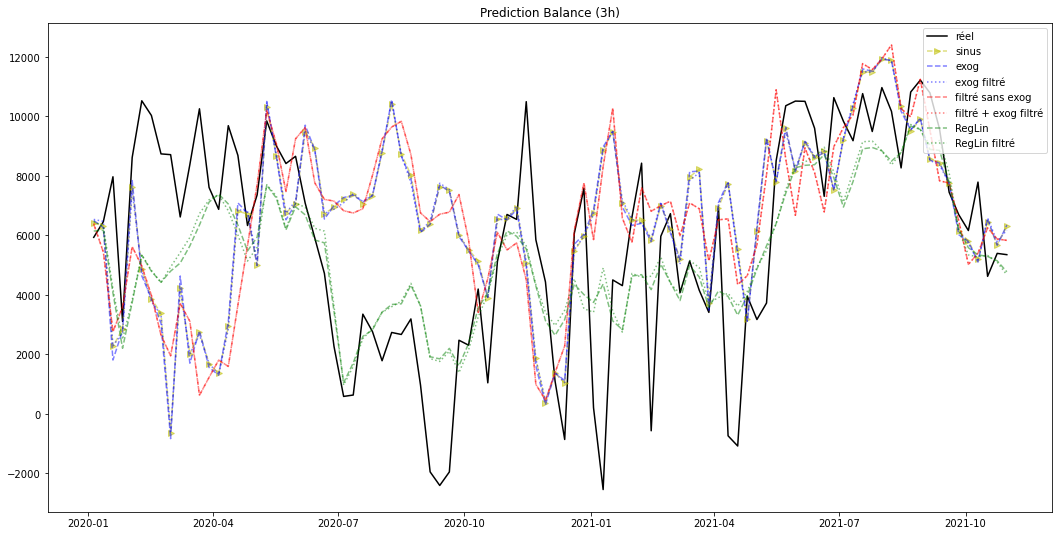

In [81]:
plt.figure(figsize=(18,9))
plt.plot(bilan['Balance'].resample('W').mean(), color = 'k', label = 'réel')
plt.plot(bilan['Bal_p_sinus'].resample('W').mean(), color = 'y', linestyle = '--', alpha = 0.5, label = 'sinus', marker = '>')
plt.plot(bilan['Bal_p_exog'].resample('W').mean(), color = 'b', linestyle = '--', alpha = 0.5, label = 'exog')
plt.plot(bilan['Bal_p_filter'].resample('W').mean(), color = 'b', linestyle = ':', alpha = 0.5, label = 'exog filtré')
plt.plot(bilan['Bal_p_reduit_noreg'].resample('W').mean(), color = 'r', linestyle = '--', alpha = 0.5, label = 'filtré sans exog')
plt.plot(bilan['Bal_p_reduit'].resample('W').mean(), color = 'r', linestyle = ':', alpha = 0.5, label = 'filtré + exog filtré')
plt.plot(bilan['Bal_p_LinReg'].resample('W').mean(), color = 'g', linestyle = '--', alpha = 0.5, label = 'RegLin')
plt.plot(bilan['Bal_p_LinReg_filter'].resample('W').mean(), color = 'g', linestyle = ':', alpha = 0.5, label = 'RegLin filtré')
plt.legend(loc = 'upper right')
plt.title('Prediction Balance (3h)')
plt.savefig('./results/pred_balance_3h.png');

# Synthèse des erreurs

In [82]:
erreur = bilan[['Err_sinus',
       'Err_exog',
       'Err_exog_filter',
       'Err_filter_noreg',
       'Err_filter_exog_filter',
       'Err_LinReg',
       'Err_LinReg_filter'
      ]].describe()
erreur

,Err_sinus,Err_exog,Err_exog_filter,Err_filter_noreg,Err_filter_exog_filter,Err_LinReg,Err_LinReg_filter
count,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000
mean,4109.909353,4151.556553,4105.861144,3987.694835,3982.192045,2828.162040,2833.034731
std,3173.677062,3225.331933,3194.299080,3037.311857,3034.191739,2136.098942,2161.065129
min,0.993297,1.561585,0.529502,1.034510,0.110035,0.480668,1.146680
25%,1554.944447,1546.144263,1529.116372,1532.972698,1520.206301,1141.513984,1153.299376
50%,3417.630125,3422.365118,3400.024030,3306.899114,3295.490634,2377.499053,2365.009310
75%,5936.449382,6056.400883,5960.077629,5853.248982,5824.538351,4020.421812,4042.584214
max,16307.262101,17663.851968,16256.116401,16961.827698,17329.860440,15313.798458,15593.393882


In [83]:
bilan.to_csv('./results/bilan_balance_3h.csv', sep = ';')
erreur.to_csv('./results/erreur_balance_3h.csv', sep = ';')